### Note: Keep input file phq_all_final.csv in the same folder

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

Read data

In [2]:
df = pd.read_csv("phq_all_final.csv")

df["date"] = pd.to_datetime(df.date.values)
df["patient_date_created"] = pd.to_datetime(df.date.values)

In [3]:
num_uni_id = df.patient_id.nunique()
print(f"Number of unique patients: {num_uni_id}")

Number of unique patients: 15502


In [4]:
def plot_feat_cnt(feat, fname):
    cnt = Counter(feat)
    
    fig, ax = plt.subplots()
    cmap = plt.get_cmap('Set2')
    colors=[cmap(i) for i in range(len(cnt.keys()))]
    
    x,y = zip(*sorted(list(zip(list(cnt.keys()), list(cnt.values()))), key=lambda val: val[0]))
    ax.bar(range(len(x)), y, color=colors)
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x)
    ax.set_ylabel("Frequency", fontsize=14)
    ax.set_title(fname, fontsize=14);

Check years in the data set

In [5]:
years = df.date.apply(lambda val: val.year).values
days = df.date.apply(lambda val: val.day).values
hours = df.date.apply(lambda val: val.hour).values

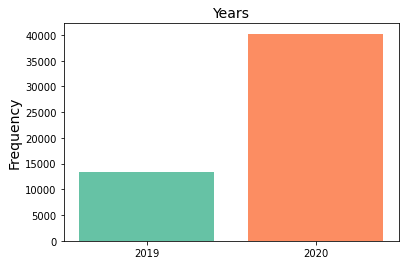

In [6]:
plot_feat_cnt(years, "Years")

Note, most of the data is from year 2020

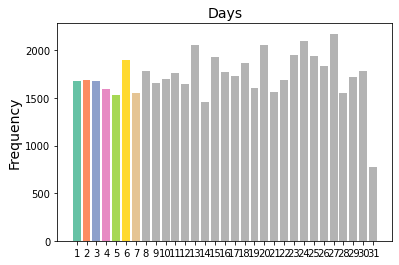

In [7]:
plot_feat_cnt(days, "Days")

We can see some weekly pattern where after ALMOST 6 days we see peak of test frquencies.

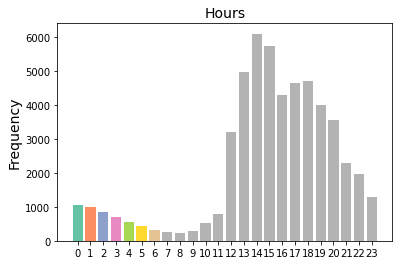

In [8]:
plot_feat_cnt(hours, "Hours")

Most of the tests are taken in between 12 noon to 8 pm.

Let's now check how many tests each patients take

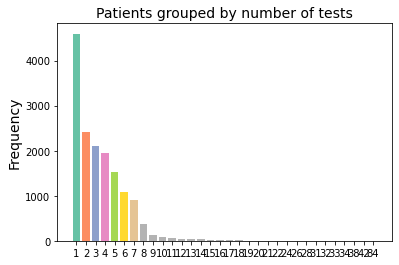

In [9]:
plot_feat_cnt(df.patient_id.value_counts().values, "Patients grouped by number of tests")

Let's now check health output of the tests

In [10]:
def severity_level(score):
    if score<=5:
        return "Low"
    elif score<=10:
        return "Mild"
    elif score<=15:
        return "Moderate"
    elif score<=21:
        return "Severe"

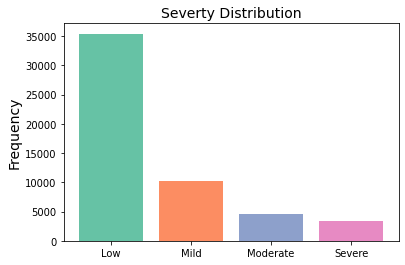

In [11]:
plot_feat_cnt(df.score.apply(severity_level).values, "Severty Distribution")

We can see most of the tests result in Low severity and very less tests result in Severity.

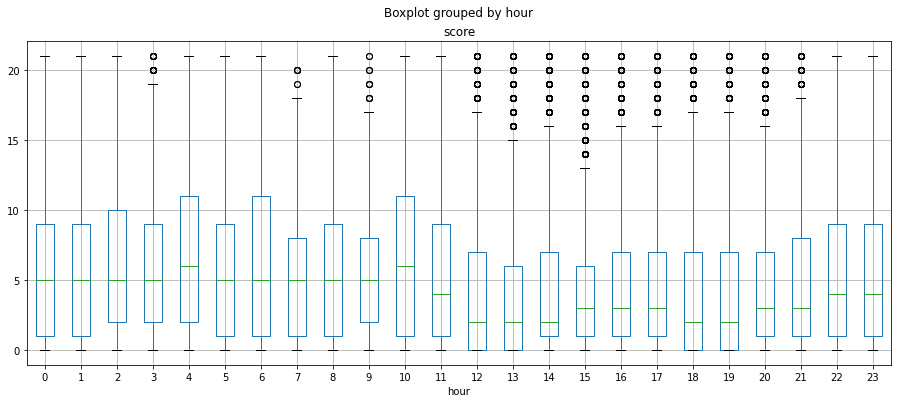

In [12]:
df["hour"] = hours

fig, ax = plt.subplots(figsize=(15,6))
df.boxplot(column="score", by="hour", ax=ax);

We can see that tests taken after 10 o'clock in the morning have lower median score than 5.

In [13]:
df = df.sort_values(by=["patient_id", "date"])
df["interval"] = df.groupby(by="patient_id")["date"].diff().to_frame()
df["interval"] = df["interval"].apply(lambda val: val.days)
df_intervals = df.groupby("patient_id", as_index=False)["interval"].mean()

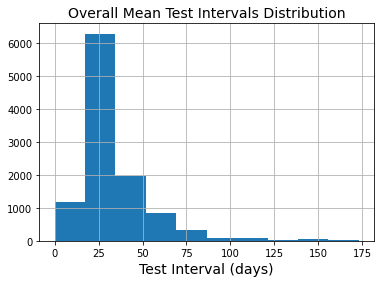

In [14]:
fig, ax = plt.subplots()
df_intervals[df_intervals["interval"].isnull() == False]["interval"].hist(ax=ax)
ax.set_xlabel("Test Interval (days)", fontsize=14)
ax.set_title("Overall Mean Test Intervals Distribution", fontsize=14);

Note for above calculation we considered patients with at least 2 tests taken.<br>
We can see right skewed distribution in the above plot.<br>
Note that we calculated average of test intervals for every patient (exluding some).<br>
Hence, above distribution represents average test interval for any patient (excluding some).<br>
Hence, we can conclude that majority of patients take ONLY one test every 25 days.

It has been considered that patients with test scores 10 or greater need further clinical evaluation.

In [15]:
patients_of_concern = df[df.score>=10]["patient_id"].unique()
num_of_patients_of_concern = len(patients_of_concern)
print(f"Out of our total cutomer base {num_of_patients_of_concern} patients require further clinical evaluation.\nThis accounts for {round(100*num_of_patients_of_concern/num_uni_id,2)}% of our cutomer base.")

Out of our total cutomer base 4436 patients require further clinical evaluation.
This accounts for 28.62% of our cutomer base.


Let's measure user engagement.

In [16]:
patient_cnt = 0
for user in patients_of_concern:
    num_of_tests = df[df["patient_id"] == user].shape[0]
    if num_of_tests>1:
        patient_cnt+=1

In [17]:
print(f"{round(100*patient_cnt/num_of_patients_of_concern,2)}% patients who require further clinical evaluation take more than one test on our platform.")

patient_test_counts = df.groupby("patient_id")["patient_id"].count().values

print(f"{round(100*len(patient_test_counts[patient_test_counts>1])/num_uni_id, 2)}% all patients take more than one test on our platform.")

74.64% patients who require further clinical evaluation take more than one test on our platform.
70.35% all patients take more than one test on our platform.


## Summary:
<ol>
    <li>Most of our data comes from 2020</li>
    <li>Number of tests peak ALMOST every 6 days.</li>
    <li>Most of the tests are taken in between 12 noon to 8 pm.</li>
    <li>More than 4000 patients take only 1 test.</li>
    <li>Majority of the patients take 8 or less tests.</li>
    <li>Order of frequency of severity as follows: Low > Mild > Moderate > Severe</li>
    <li>The median test score taken after 10 am is under 5.</li>
    <li>Distribution of mean test interval for patients is righ skewed and mode of the distribution is 25 days.</li>
    <li>28.62% of our customer base require further clinical evaluation.</li>
    <li>74.64% of patients who require further clinical evaluation take more than one test on our platform.</li>
    <li>Whereas 70.35% of our entire customer base take more than one test one the platform.</li>
</ol>

## Data Assumptions:
<ul>
    <li>We assume that any two patients does not affect test results of each other. That is test results of any two patients are independent of each other.</li>
    <li>We also assume that test results are not function of days. That is test taken today or tomorrow does not affect test results. Rather test results are function of treatment.</li>
</ul>

## Additional information that would be important to collect:

### Goal: To be able to visualize progress for mental health providers and patients.

Hence, we have two objectives:
<ol>
    <li>Health Progess for Patients (Individual Level)</li>
    <li>Health progess for Population (Provider Level)</li>
</ol>

Data that would be important to collect:
<ul>
    <li>We can ask patients (users) list of questions on their recent habits. This will enable us show which habits contribute improvement in their health and which are not.</li>
    <li>Provider-Patient information is important collect because then we will be able to visualize provider level statistics on population health.</li>
    <li>Also we can help patients (users) by comparing provider level health statistics.</li>
    <li>We can ask providers which treatments they suggested their patients. From this information we can help providers better understand which treatments actually work.</li>
    <li>Instead of collecting just GAD-7 assesement score we could collect individual 7 question answers to help providers and patients indentify areas of improvement.</li>
    <li>Last but not least the patient level social determinants of health will be very important to identify key factors of determining health of the patients. This will help providers better understand their patients and improve their health.</li>
</ul>